In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

## 导入MNIST数据集

In [2]:
# this data
mnist = input_data.read_data_sets("MNIST_data" , one_hot=True)

W0918 10:49:14.729125  1956 deprecation.py:323] From <ipython-input-2-c5b7a064ca4c>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0918 10:49:14.773042  1956 deprecation.py:323] From C:\Users\24301\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0918 10:49:14.777034  1956 deprecation.py:323] From C:\Users\24301\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
I

Extracting MNIST_data\train-images-idx3-ubyte.gz


W0918 10:49:15.263131  1956 deprecation.py:323] From C:\Users\24301\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0918 10:49:15.276605  1956 deprecation.py:323] From C:\Users\24301\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.
W0918 10:49:15.379914  1956 deprecation.py:323] From C:\Users\24301\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\contrib\learn\python\learn\datasets\mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is

Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## 定义参数：学习效率，训练次数，每批的大小

In [3]:
# hyperparameters
lr = 0.001
training_iters = 100000
batch_size = 128

## 定义图片参数：列，行，隐藏神经元，类别

In [4]:
n_inputs = 28 # MNIST data input (img shape : 28*28)
n_steps = 28 # time steps
n_hidden_units = 128 # neurons in hidden layer
n_classes = 10 # MNIST classes (0-9 digits)

In [5]:
# tf Graph input 
x = tf.placeholder(tf.float32 , [None , n_steps ,n_inputs])
y = tf.placeholder(tf.float32 , [None , n_classes])

## 定义weights和biases，都有'in'和'out'两种值对应输入输出

In [6]:
# Define weights
# 一行一行扫描，图片是28*28的
weights = {
    # (28 , 128)
    'in' : tf.Variable(tf.random_normal([n_inputs , n_hidden_units])),
    # (128 , 10)
    'out' : tf.Variable(tf.random_normal([n_hidden_units , n_classes]))
}
biases = {
    # （128 ， ）
    'in' : tf.Variable(tf.constant(0.1 , shape=[n_hidden_units ,])),
    # (10 , )
    'out' : tf.Variable(tf.constant(0.1 ,shape=[n_classes ,]))
}

## 定义RNN函数
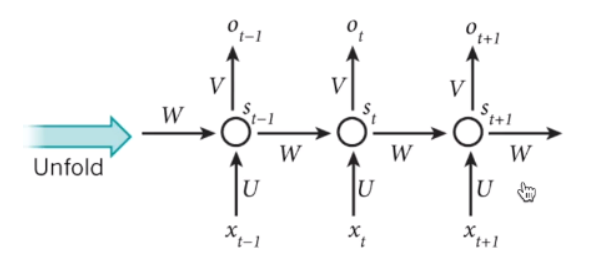

In [7]:
def RNN(X , weights , biases):
    # hidden layer for input to cell

    # X(128 batch , 28 steps ,28 inputs)==>(128*28 , 28 inputs)
    X = tf.reshape(X ,[-1 , n_inputs]) # (128 batch * 28 steps ,28 inputs)
    X_in = tf.matmul(X , weights['in']) + biases['in'] # (128 batch * 28 steps , 128 hidden)
    X_in = tf.reshape(X_in ,[-1 , n_steps , n_hidden_units]) # (128 batch , 28 steps , 128 hidden)
    
    # cell
    # 遗忘系数forget_bias=1.0是不忘记 ; 
    # state_is_tuple=True 表示返回的状态用一个元组表示，LSTMCell包括两个元素(c_state , m_state)
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden_units , forget_bias=1.0 , state_is_tuple=True)
    # lstm cell is divided into two parts (c_state , m_state) ; c_state 是主线 ， m_state 是分线
    _init_state = lstm_cell.zero_state(batch_size , dtype=tf.float32) # 状态初始化函数，RNN每一步处理结果是一个state
    
    # tf.nn.dynamic_rnn()的优点在于对尺度不同的数据的处理上，会减少计算量
    # time_major=False 是看n_steps是不是在主要维度上（第一个维度）:(128 batch ,28 steps ,128 hidden)
    outputs , states = tf.nn.dynamic_rnn(lstm_cell , X_in ,initial_state=_init_state , time_major=False)
    
    # hidden layer for output as the final results
    ## results = tf.matmul(states[1] , weights['out']) + biases['out']
    
    # or
    # upack to list[(batch , outputs)..]*steps
    # 用 tf.stack和tf.unstack 代替 tf.pack和tf.unpack
    outputs = tf.unstack(tf.transpose(outputs , [1 ,0 , 2])) # states is the last outputs;[n_steps , batch_size , outputs_size]
    results = tf.matmul(outputs[-1] , weights['out']) + biases['out']
    
    return results

In [8]:
pred = RNN(x , weights ,biases)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred , labels=y))
train_op = tf.train.AdamOptimizer(lr).minimize(cost)

correct_pred = tf.equal(tf.argmax(pred , 1) , tf.argmax(y , 1)) # 1表示按行比较
accuracy = tf.reduce_mean(tf.cast(correct_pred ,tf.float32))

W0918 10:49:16.446427  1956 deprecation.py:323] From <ipython-input-7-783ab95217a9>:12: BasicLSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0918 10:49:16.550233  1956 deprecation.py:323] From <ipython-input-7-783ab95217a9>:18: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
W0918 10:49:16.858660  1956 deprecation.py:506] From C:\Users\24301\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of p

In [9]:
init = tf.global_variables_initializer()

In [10]:
with tf.Session() as sess:
    sess.run(init)
    step = 0
    while step * batch_size < training_iters :
        batch_xs , batch_ys = mnist.train.next_batch(batch_size)
        batch_xs = batch_xs.reshape([batch_size , n_steps , n_inputs])
        sess.run([train_op] , feed_dict={x:batch_xs , y:batch_ys,})
        if step%20 == 0:
            print(sess.run(accuracy , feed_dict={x:batch_xs , y:batch_ys,}))

0.1796875
0.21875
0.28125
0.3125
0.4765625
0.4921875
0.5859375
0.515625
0.5546875
0.46875
0.4453125
0.5234375
0.5546875
0.625
0.625
0.609375
0.6328125
0.609375
0.5625
0.6875
0.640625
0.7109375
0.6875
0.6015625
0.6328125
0.625
0.7109375
0.6875
0.7734375
0.796875
0.6875
0.6875
0.8125
0.7578125
0.7265625
0.796875
0.703125
0.65625
0.796875
0.7734375
0.78125
0.8125
0.78125
0.7734375
0.7421875
0.7578125
0.796875
0.8203125
0.8515625
0.828125
0.8359375
0.734375
0.796875
0.8046875
0.765625
0.8125
0.8203125
0.75
0.8046875
0.8046875


KeyboardInterrupt: 